# Scalability for a few key algorithms

We consider 4 commonly used graph algorithms:
* Leiden/Louvain clustering
* Coreness (a.k.a. core numbers, the largest k-cores for each vertex)
* Pagerank centrality
* Triad census (for directed graphs)

First, we compare timings betweeen **networkx** and **igraph** for graphs with $n = 2^k$ nodes and $m = 2^{(k+4)}$ edges for $8 \le k \le 16$. We clearly see the advantage in using iGraph for all of those. Since Leiden is not available with networkx, we use the Louvain algorithm.

Next, we run the same algorithms (except we use the faster Leiden instead of Louvain) with **igraph** only, for a wider range for $8 \le k \le 23$, thus up to 8 million vertices and 128 million edges.

The results below were obtained on a MacBook Pro running on macOS Monterey 12.6.

### summary of observations

* The scalability is much better with igraph for all algorithms; it is particularly obvious for the triad census algorithm.
* Even for the largest graph we considered (8 million vertices, 128 million edges), the Pagerank and Coreness algorithms are very fast. For such a large graph, triad census and Leiden are still feasible, taking under half an hour.
* Looking at log-log plots yields almost perfect lines for all algorithms; we estimate the slopes for those via linear regression.


In [1]:
!pip install networkx
!pip install python-louvain

In [2]:
## path to the datasets
datadir='../Datasets/'

## required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import partition_igraph
from collections import Counter
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random
import networkx as nx
import time
from community import community_louvain as louvain

### running igraph and networkx

In [3]:
L = []
R = np.arange(8,17)
for e in R:
    v = []
    ## build graph
    n = 2**e
    m = 16*n
    g = ig.Graph.Erdos_Renyi(n=n, m=m)
    G = g.to_networkx()
    ## Louvain
    start = time.time()
    pr = louvain.best_partition(G)
    end = time.time()
    v.append(end-start)
    start = time.time()
    pr = g.community_multilevel()
    end = time.time()
    v.append(end-start)
    ## Coreness
    start = time.time()
    pr = nx.core_number(G)
    end = time.time()
    v.append(end-start)
    start = time.time()
    pr = g.coreness()
    end = time.time()
    v.append(end-start)
    ## PageRank
    start = time.time()
    pr = nx.pagerank(G)
    end = time.time()
    v.append(end-start)
    start = time.time()
    pr = g.pagerank(implementation='arpack')
    end = time.time()
    v.append(end-start)
    ## triadic census
    g = ig.Graph.Erdos_Renyi(n=n, m=m, directed=True)
    G = g.to_networkx()
    start = time.time()
    pr = nx.triadic_census(G)
    end = time.time()
    v.append(end-start)
    start = time.time()
    pr = g.triad_census()
    end = time.time()
    v.append(end-start)
    ## store
    L.append(v)
df = pd.DataFrame(L, columns=['ML(nx)','ML(ig)','CO(nx)','CO(ig)','PR(nx)','PR(ig)','TC(nx)','TC(ig)'])

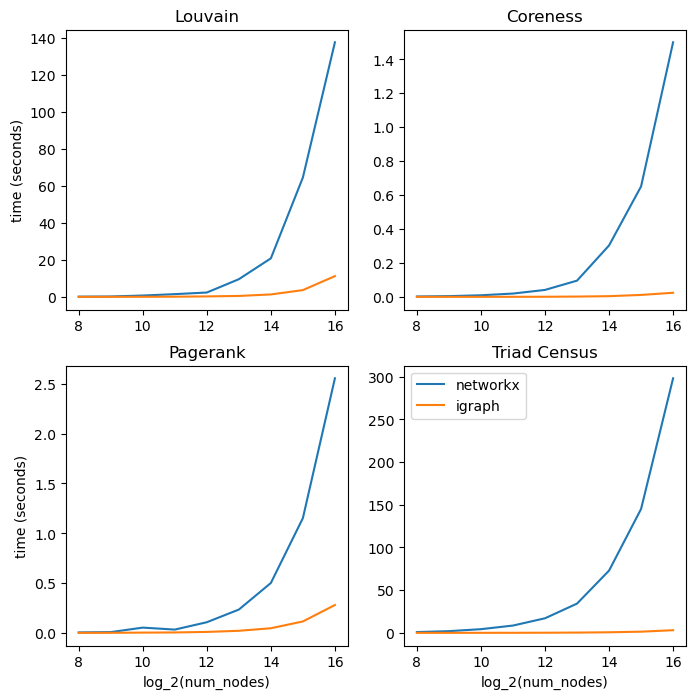

In [4]:
plt.figure(figsize=(8,8))

plt.subplot(221)
plt.plot(R,df['ML(nx)'],label='networkx')
plt.plot(R,df['ML(ig)'],label='igraph')
plt.ylabel('time (seconds)')
plt.title('Louvain');

plt.subplot(222)
plt.plot(R,df['CO(nx)'],label='networkx')
plt.plot(R,df['CO(ig)'],label='igraph')
plt.title('Coreness');

plt.subplot(223)
plt.plot(R,df['PR(nx)'],label='networkx')
plt.plot(R,df['PR(ig)'],label='igraph')
plt.xlabel('log_2(num_nodes)')
plt.ylabel('time (seconds)')
plt.title('Pagerank');

plt.subplot(224)
plt.plot(R,df['TC(nx)'],label='networkx')
plt.plot(R,df['TC(ig)'],label='igraph')
plt.xlabel('log_2(num_nodes)')
plt.legend()
plt.title('Triad Census');

plt.savefig('timings_1.png')

In [5]:
L = []
R = np.arange(8,24)
for e in R:
    v = []
    ## build graph
    n = 2**e
    m = 16*n
    g = ig.Graph.Erdos_Renyi(n=n, m=m)
    ## Leiden
    start = time.time()
    pr = g.community_leiden(objective_function='modularity')
    end = time.time()
    v.append(end-start)
    ## CO
    start = time.time()
    pr = g.coreness()
    end = time.time()
    v.append(end-start)
    ## PageRank
    start = time.time()
    pr = g.pagerank(implementation='arpack')
    end = time.time()
    v.append(end-start)
    ## triadic census
    g = ig.Graph.Erdos_Renyi(n=n, m=m, directed=True)
    start = time.time()
    pr = g.triad_census()
    end = time.time()
    v.append(end-start)
    ## store
    L.append(v)
df = pd.DataFrame(L, columns=['LE(ig)','CO(ig)','PR(ig)','TC(ig)'])

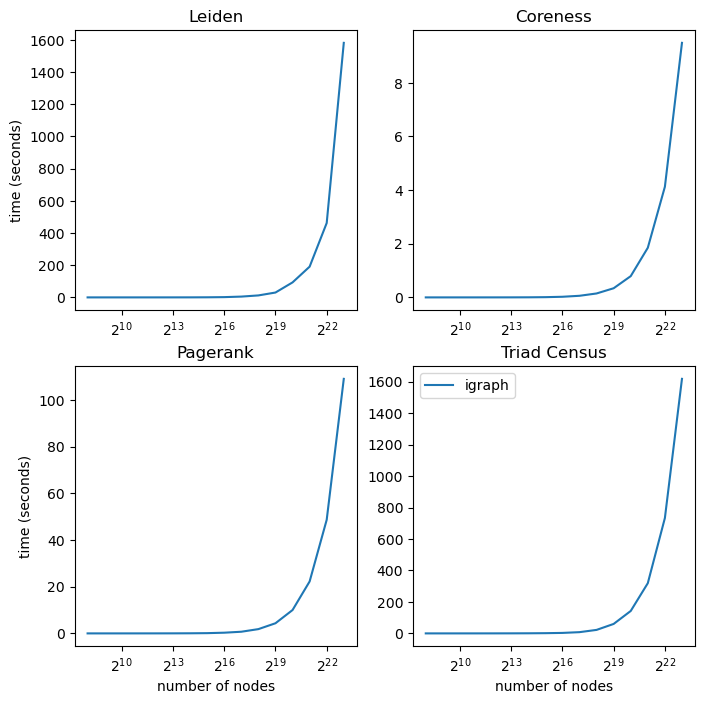

In [12]:
plt.figure(figsize=(8,8))

R_exp = [2**i for i in R]

plt.subplot(221)
plt.semilogx(R_exp,df['LE(ig)'],label='igraph', base=2)
plt.ylabel('time (seconds)')
plt.title('Leiden');

plt.subplot(222)
plt.semilogx(R_exp,df['CO(ig)'],label='igraph', base=2)
plt.title('Coreness');

plt.subplot(223)
plt.semilogx(R_exp,df['PR(ig)'],label='igraph', base=2)
plt.xlabel('number of nodes')
plt.ylabel('time (seconds)')
plt.title('Pagerank');

plt.subplot(224)
plt.semilogx(R_exp,df['TC(ig)'],label='igraph', base=2)
plt.xlabel('number of nodes')
plt.legend()
plt.title('Triad Census');

plt.savefig('timings_2.png')


### Looking as log-log plots

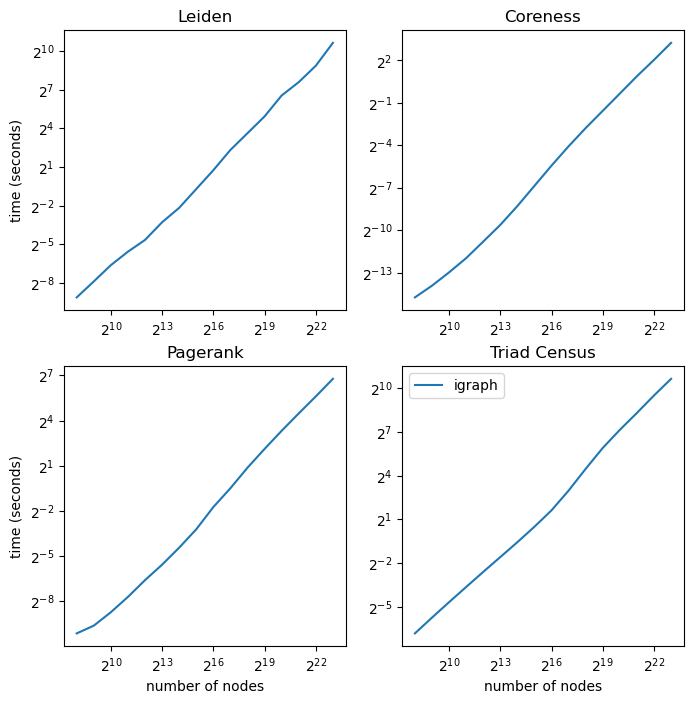

In [14]:
plt.figure(figsize=(8,8))

plt.subplot(221)
plt.loglog(R_exp,df['LE(ig)'],label='igraph', base=2)
plt.ylabel('time (seconds)')
plt.title('Leiden');

plt.subplot(222)
plt.loglog(R_exp,df['CO(ig)'],label='igraph', base=2)
plt.title('Coreness');

plt.subplot(223)
plt.loglog(R_exp,df['PR(ig)'],label='igraph', base=2)
plt.xlabel('number of nodes')
plt.ylabel('time (seconds)')
plt.title('Pagerank');

plt.subplot(224)
plt.loglog(R_exp,df['TC(ig)'],label='igraph', base=2)
plt.xlabel('number of nodes')
plt.legend()
plt.title('Triad Census');

plt.savefig('timings_3.png')


#### Slopes for the log-log plots

In [33]:
from scipy import stats
lr = stats.linregress(R,[np.log2(i) for i in df['LE(ig)']])
print('Leiden:',lr.slope)
lr = stats.linregress(R,[np.log2(i) for i in df['CO(ig)']])
print('Coreness:',lr.slope)
lr = stats.linregress(R,[np.log2(i) for i in df['PR(ig)']])
print('Pagerank:',lr.slope)
lr = stats.linregress(R,[np.log2(i) for i in df['TC(ig)']])
print('Triad census:',lr.slope)


Leiden: 1.3177870270598904
Coreness: 1.245713107382355
Pagerank: 1.1793546109219235
Triad census: 1.1811542222394804
